In [0]:
%sh
pip install wordcloud


You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-659c7da2-9d50-4028-96a6-9c329b347631/bin/python -m pip install --upgrade pip' command.


In [0]:
pip install --upgrade pillow

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from wordcloud import WordCloud
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

In [0]:
spark = SparkSession.builder.getOrCreate()
skills = spark.read.format('csv').option('header', "false").load('/FileStore/tables/skill2vec_50K.csv.gz')
technologySkills = spark.read.option('header','true').option('sep','\t').csv('/FileStore/tables/Technology_Skills.txt')
#Uncomment to test 1k and 10k subsets
skills_1k = spark.read.format('csv').option('header', "false").load('/FileStore/tables/skill2vec_1K.csv')
skills_10k = spark.read.format("csv").option("header", "false").load("dbfs:/FileStore/tables/skill2vec_10K.csv")

In [0]:
def unique_count(skills,size):
    #Checking Null values in the first column
    skills.select([F.count(F.when(F.isnan('_c0') | F.col('_c0').isNull(), '_c0')).alias('Null Values in First Column')]).show()
    #Getting the distinct job descriptions via 'count_distinct'
    print("The answer to question 1 ({0}):".format(size))
    skills.select(F.count_distinct(skills._c0).alias('Distinct Job Descriptions')).show()
    

In [0]:
def pre_processing(skills):
     #'Cleaning/pre-processing' the data, by arranging every skill in a JD as a list and removing nulls.
    column_names = skills.drop(skills.columns[0]).columns
    skill_listed = skills.select(skills._c0,F.array(column_names).alias('skill_list'))
    skill_listed = skill_listed.withColumn('skill_list',F.array_except('skill_list',F.array(F.lit(None)))) #skill_list is the new column where each row is a list of skills for the particular JD.
    skill_listed = skill_listed.withColumn('skill_count',F.size(F.col('skill_list'))) #skill_count is the count of elements in each row of skill_list
    return skill_listed

In [0]:
def top_skills(skill_listed,size):   
    #.explode() helps us to map each skill for a JD, column wise.
    individualSkills = skill_listed.withColumn('skills',F.explode(F.col('skill_list')))
    individualSkillCount = individualSkills.groupBy(F.col('skills')).count().sort('count',ascending = False)
    return individualSkills,individualSkillCount


In [0]:
def skill_count(skill_listed, size):
    skill_count = skill_listed.groupBy(F.col('skill_count')).agg(F.count('skill_count').alias('Freq')).sort('Freq',ascending = False)
    return skill_count

In [0]:
def lower_case_skills(individualSkills, size):
    individualSkillsLowerCased = individualSkills.withColumn('skills_lower_cased', F.lower(F.col('skills')))
    individualSkillsLowerCasedCount = individualSkillsLowerCased.groupBy(F.col('skills_lower_cased')).count().sort('count',ascending = False)
    return individualSkillsLowerCased,individualSkillsLowerCasedCount

In [0]:
def join_skills(technologySkills,individualSkillsLowerCased,size):
    technologySkills = technologySkills.withColumn('Example',F.lower(F.col('Example')))  #technologySkills is the table from O*NET
    joinedSkills = individualSkillsLowerCased.join(technologySkills,individualSkillsLowerCased['skills_lower_cased'] == technologySkills['Example'])    
    hot_commodities = joinedSkills.groupBy('Commodity Title').count().sort('count',ascending = False)
    return joinedSkills,hot_commodities

In [0]:
def assignment_answers(skills,technologySkills,size):
    unique_count(skills,size)
    skill_listed = pre_processing(skills)
    
    individualSkills,individualSkillCount = top_skills(skill_listed,size)
    print('The answer two question 2 ({0}):'.format(size))
    individualSkillCount.show(10)
    
    skill_counts = skill_count(skill_listed, size)
    print('The answer two question 3 ({0}):'.format(size))
    skill_counts.show(5)
    
    individualSkillsLowerCased,individualSkillsLowerCasedCount = lower_case_skills(individualSkills, size)
    print('The answer to question 4 ({0}):'.format(size))
    individualSkillsLowerCasedCount.show(10)
    
    print('The answers for question 5 ({0}): \n Before joining the table'.format(size))
    individualSkillsLowerCased.select(F.count(F.col('skills_lower_cased')).alias('skill_count')).show()
    joinedSkills,hot_commodities = join_skills(technologySkills,individualSkillsLowerCased,size)
    print('After joining the table')
    joinedSkills.select(F.count(F.col('skills_lower_cased')).alias('skill_count')).show()
    print('The answer for question 6 ({0}):'.format(size))
    hot_commodities.show(10, truncate = False)


In [0]:
#uncomment if you need assignment answers
#assignment_answers(skills,technologySkills,'50K')

In [0]:
skill_listed = pre_processing(skills)
individualSkills,individualSkillCount = top_skills(skill_listed,'50K')
individualSkillsLowerCased,individualSkillsLowerCasedCount = lower_case_skills(individualSkills, '50K')

In [0]:
display(individualSkillCount.take(10))

skills,count
Java,1911
Javascript,1770
Sales,1705
Business Development,1545
Web Technologies,1313
Communication Skills,1305
development,1238
Marketing,1184
Finance,1078
HTML,1067


Databricks visualization. Run in Databricks to view.

In [0]:
skill_dict = {row['skills']: row['count'] 
              for row in individualSkillCount.collect()}

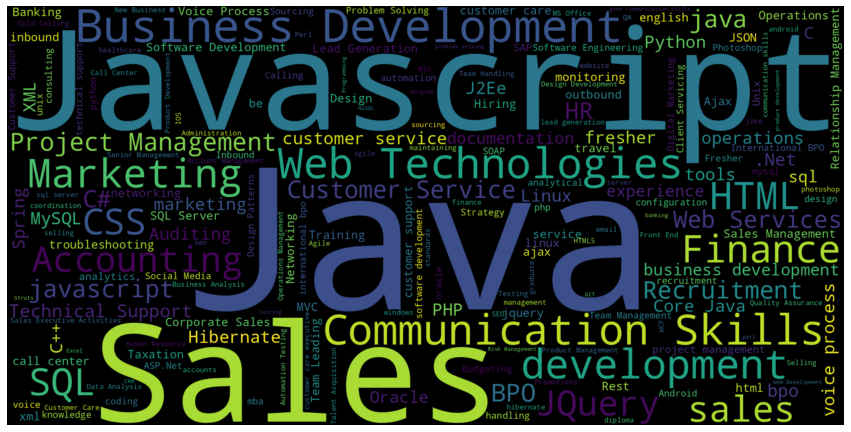

In [0]:
#note: in case word cloud fails with an error of truefont please install pillow by running cell 2 again, as there is some inconsistency in the plugin being installed.
wordcloud = WordCloud(background_color="black", height = 1000, width = 2000).generate_from_frequencies(skill_dict)

# Display the generated image:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()


In [0]:
display(individualSkillsLowerCasedCount.take(10))

skills_lower_cased,count
java,2759
javascript,2738
sales,2680
business development,2108
marketing,1809
sql,1564
jquery,1547
html,1539
communication skills,1537
bpo,1530


Databricks visualization. Run in Databricks to view.

In [0]:
lower_cased_skill_dict = {row['skills_lower_cased']: row['count'] 
              for row in individualSkillsLowerCasedCount.collect()}

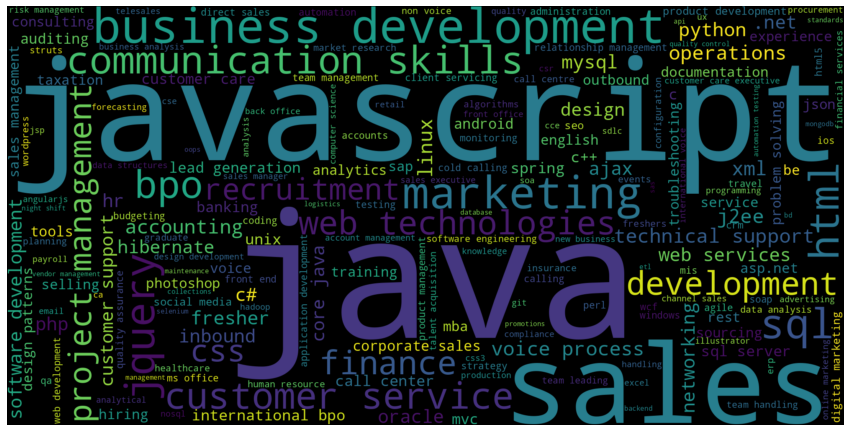

In [0]:
#note: in case word cloud fails with an error of truefont please install pillow by running cell 2 again, as there is some inconsistency in the plugin being installed.
updatedWordCloud = WordCloud(background_color="black", height = 1000, width = 2000).generate_from_frequencies(lower_cased_skill_dict)

# Display the generated image:
plt.figure(figsize=(15,15))
plt.imshow(updatedWordCloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
skill_counts = skill_count(skill_listed, '50K')
display(skill_counts.take(5))

skill_count,Freq
10,10477
5,3432
6,3405
1,3386
7,3345


Databricks visualization. Run in Databricks to view.

In [0]:
joinedSkills,hot_commodities = join_skills(technologySkills,individualSkillsLowerCased,'50K')
display(hot_commodities.take(10))

Commodity Title,count
Object or component oriented development software,324521
Web platform development software,298754
Operating system software,190926
Development environment software,53013
Data base management system software,44132
Analytical or scientific software,33552
Web page creation and editing software,31682
Data base user interface and query software,29436
Spreadsheet software,18568
File versioning software,13846


Databricks visualization. Run in Databricks to view.

In [0]:
display(hot_commodities.tail(10))

Commodity Title,count
Metadata management software,7
Materials requirements planning logistics and supply chain software,6
Communications server software,6
Content workflow software,5
Music or sound editing software,5
Computer aided manufacturing CAM software,4
Financial analysis software,2
Risk management data and analysis software,2
Switch or router software,1
Data conversion software,1
